In [ ]:
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
import os
from typing import Tuple, Dict, Any, List

In [ ]:
# --- Global Parameters ---
# These can be easily modified for experimentation.

# Data and Environment settings
DATA_FILE = 'SIT_84.csv'
WEAR_THRESHOLD = 290.0  # Threshold for tool wear before it's considered failed

# Reward structure
R1_CONTINUE = 2.0      # Reward for continuing with a healthy tool
R2_REPLACE = -5.0      # Reward for a timely replacement
R3_VIOLATION = -30.0   # Penalty for violating the wear threshold

# Training settings
EPISODES = 1_000          # Total number of episodes to train each agent
LEARNING_RATE = 5e-3    # Learning rate for optimizers
GAMMA = 0.99            # Discount factor for future rewards

# Plotting settings
SMOOTH_WINDOW = 100     # Window size for moving average smoothing on plots

### Plotting

In [ ]:
# --- Task 4: Plotting the Comparison ---

def smooth(data: List[float], window_size: int) -> np.ndarray:
    """
    Applies a simple moving average to a list of data.
    Handles NaNs by ignoring them in the window calculation.
    """
    return pd.Series(data).rolling(window=window_size, min_periods=1).mean().to_numpy()

def plot_metrics(reinforce_metrics: Dict, ppo_metrics: Dict, window: int):
    """
    Generates and displays the 4 comparison plots.
    """
    fig, axs = plt.subplots(2, 2, figsize=(16, 8))
    fig.suptitle('REINFORCE vs. PPO Performance for Predictive Maintenance', fontsize=18)

    # 1. Learning Curves (Average Reward)
    axs[0, 0].plot(smooth(reinforce_metrics['rewards'], window), label='REINFORCE')
    axs[0, 0].plot(smooth(ppo_metrics['rewards'], window), label='PPO')
    axs[0, 0].set_title('Learning Curve (Smoothed Average Reward)')
    axs[0, 0].set_xlabel('Episode')
    axs[0, 0].set_ylabel('Average Reward')
    axs[0, 0].legend()
    axs[0, 0].grid(True, linestyle='--', alpha=0.6)

    # 2. Total Replacements
    axs[0, 1].plot(smooth(reinforce_metrics['replacements'], window), label='REINFORCE')
    axs[0, 1].plot(smooth(ppo_metrics['replacements'], window), label='PPO')
    axs[0, 1].set_title('Replacements per episode (Smoothed)')
    axs[0, 1].set_xlabel('Episode')
    axs[0, 1].set_ylabel('Replacement Rate')
    axs[0, 1].legend()
    axs[0, 1].grid(True, linestyle='--', alpha=0.6)

    # 3. Threshold Violations
    axs[1, 0].plot(smooth(reinforce_metrics['violations'], window), label='REINFORCE')
    axs[1, 0].plot(smooth(ppo_metrics['violations'], window), label='PPO')
    axs[1, 0].set_title('Threshold Violations per episode (Smoothed)')
    axs[1, 0].set_xlabel('Episode')
    axs[1, 0].set_ylabel('Violation Rate')
    axs[1, 0].legend()
    axs[1, 0].grid(True, linestyle='--', alpha=0.6)

    # 4. Wear Margins
    # Use pandas to handle NaNs gracefully before smoothing
    reinforce_margins = pd.Series(reinforce_metrics['margins']).rolling(window, min_periods=1).mean()
    ppo_margins = pd.Series(ppo_metrics['margins']).rolling(window, min_periods=1).mean()
    axs[1, 1].plot(reinforce_margins, label='REINFORCE')
    axs[1, 1].plot(ppo_margins, label='PPO')
    axs[1, 1].set_title('Wear Margin Before Replacement (Smoothed)')
    axs[1, 1].set_xlabel('Episode')
    axs[1, 1].set_ylabel('Wear Margin (Lower is Better)')
    axs[1, 1].legend()
    axs[1, 1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_metrics_individual(reinforce_metrics: Dict, ppo_metrics: Dict, window: int):
    """
    Generates two separate figures with 4 subplots each - one for REINFORCE and one for PPO.
    This allows for better visualization of individual algorithm performance with their own scales.
    
    Args:
        reinforce_metrics (Dict): Dictionary containing REINFORCE metrics
        ppo_metrics (Dict): Dictionary containing PPO metrics
        window (int): Window size for smoothing the curves
    """
    H = 12
    W = 6
    # First figure for REINFORCE
    fig1, axs1 = plt.subplots(2, 2, figsize=(H, W))
    fig1.suptitle('REINFORCE Performance Metrics for Predictive Maintenance', fontsize=18)

    # Plot REINFORCE metrics
    # 1. Learning Curves (Average Reward)
    axs1[0, 0].plot(smooth(reinforce_metrics['rewards'], window), color='blue')
    axs1[0, 0].set_title('Learning Curve (Smoothed Average Reward)')
    axs1[0, 0].set_xlabel('Episode')
    axs1[0, 0].set_ylabel('Average Reward')
    axs1[0, 0].grid(True, linestyle='--', alpha=0.6)

    # 2. Total Replacements
    axs1[0, 1].plot(smooth(reinforce_metrics['replacements'], window), color='green')
    axs1[0, 1].set_title('Replacements per episode (Smoothed)')
    axs1[0, 1].set_xlabel('Episode')
    axs1[0, 1].set_ylabel('Replacement Rate')
    axs1[0, 1].grid(True, linestyle='--', alpha=0.6)

    # 3. Threshold Violations
    axs1[1, 0].plot(smooth(reinforce_metrics['violations'], window), color='red')
    axs1[1, 0].set_title('Threshold Violations per episode (Smoothed)')
    axs1[1, 0].set_xlabel('Episode')
    axs1[1, 0].set_ylabel('Violation Rate')
    axs1[1, 0].grid(True, linestyle='--', alpha=0.6)

    # 4. Wear Margins
    reinforce_margins = pd.Series(reinforce_metrics['margins']).rolling(window, min_periods=1).mean()
    axs1[1, 1].plot(reinforce_margins, color='purple')
    axs1[1, 1].set_title('Wear Margin Before Replacement (Smoothed)')
    axs1[1, 1].set_xlabel('Episode')
    axs1[1, 1].set_ylabel('Wear Margin')
    axs1[1, 1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Second figure for PPO
    fig2, axs2 = plt.subplots(2, 2, figsize=(H, W))
    fig2.suptitle('PPO Performance Metrics for Predictive Maintenance', fontsize=18)

    # Plot PPO metrics
    # 1. Learning Curves (Average Reward)
    axs2[0, 0].plot(smooth(ppo_metrics['rewards'], window), color='blue')
    axs2[0, 0].set_title('Learning Curve (Smoothed Average Reward)')
    axs2[0, 0].set_xlabel('Episode')
    axs2[0, 0].set_ylabel('Average Reward')
    axs2[0, 0].grid(True, linestyle='--', alpha=0.6)

    # 2. Total Replacements
    axs2[0, 1].plot(smooth(ppo_metrics['replacements'], window), color='green')
    axs2[0, 1].set_title('Replacements per episode (Smoothed)')
    axs2[0, 1].set_xlabel('Episode')
    axs2[0, 1].set_ylabel('Replacement Rate')
    axs2[0, 1].grid(True, linestyle='--', alpha=0.6)

    # 3. Threshold Violations
    axs2[1, 0].plot(smooth(ppo_metrics['violations'], window), color='red')
    axs2[1, 0].set_title('Threshold Violations per episode (Smoothed)')
    axs2[1, 0].set_xlabel('Episode')
    axs2[1, 0].set_ylabel('Violation Rate')
    axs2[1, 0].grid(True, linestyle='--', alpha=0.6)

    # 4. Wear Margins
    ppo_margins = pd.Series(ppo_metrics['margins']).rolling(window, min_periods=1).mean()
    axs2[1, 1].plot(ppo_margins, color='purple')
    axs2[1, 1].set_title('Wear Margin Before Replacement (Smoothed)')
    axs2[1, 1].set_xlabel('Episode')
    axs2[1, 1].set_ylabel('Wear Margin')
    axs2[1, 1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

### Main classes

In [ ]:

# --- Task 1: Custom Gymnasium Environment ---
# We define the environment for the milling tool maintenance problem.

class MT_Env(gym.Env):
    """
    Custom Gymnasium environment for Milling Tool Predictive Maintenance.

    The agent observes the current tool wear and decides whether to continue
    using the tool or replace it.

    Observation Space: A single continuous value representing the current tool wear.
    Action Space: Two discrete actions - 0 (CONTINUE) or 1 (REPLACE_TOOL).
    """
    metadata = {'render_modes': ['human']}

    def __init__(self, data_file: str, wear_threshold: float, r1: float, r2: float, r3: float):
        """
        Initializes the environment.

        Args:
            data_file (str): Path to the CSV file with sensor data and tool wear.
            wear_threshold (float): The maximum allowable tool wear.
            r1 (float): Reward for continuing.
            r2 (float): Reward for a timely replacement.
            r3 (float): Penalty for a threshold violation.
        """
        super(MT_Env, self).__init__()

        # Load and preprocess data
        if not os.path.exists(data_file):
            raise FileNotFoundError(f"Data file not found at {data_file}. Please ensure the file is in the correct directory.")
        self.df = pd.read_csv(data_file)
        self.max_steps = len(self.df) - 1

        # Environment parameters
        self.wear_threshold = wear_threshold
        self.r1_continue = r1
        self.r2_replace = r2
        self.r3_violation = r3

        # Define action and observation spaces
        self.action_space = spaces.Discrete(2)  # 0: CONTINUE, 1: REPLACE_TOOL
        # The observation is the current tool wear, normalized for better learning
        self.observation_space = spaces.Box(low=0, high=self.wear_threshold * 1.5, shape=(1,), dtype=np.float32)

        # Internal state
        self.current_step = 0

    def reset(self, seed=None, options=None) -> Tuple[np.ndarray, Dict]:
        """
        Resets the environment to its initial state for a new episode.
        """
        super().reset(seed=seed)
        self.current_step = 0
        initial_observation = self._get_observation()
        return initial_observation, {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict]:
        """
        Executes one time step within the environment.
        """
        terminated = False
        truncated = False
        reward = 0
        info = {'violation': False, 'replacement': False, 'margin': np.nan}

        current_wear = self.df.loc[self.current_step, 'tool_wear']

        if action == 1:  # Action: REPLACE_TOOL
            reward = self.r2_replace
            terminated = True
            info['replacement'] = True
            info['margin'] = self.wear_threshold - current_wear
        elif action == 0:  # Action: CONTINUE
            self.current_step += 1
            if self.current_step > self.max_steps:
                # Reached the end of data without replacement or violation
                truncated = True
                reward = 0 # No reward or penalty if data runs out
            else:
                next_wear = self.df.loc[self.current_step, 'tool_wear']
                if next_wear >= self.wear_threshold:
                    reward = self.r3_violation
                    terminated = True
                    info['violation'] = True
                else:
                    reward = self.r1_continue
        
        observation = self._get_observation()
        
        return observation, reward, terminated, truncated, info

    def _get_observation(self) -> np.ndarray:
        """
        Gets the current observation from the dataframe.
        """
        wear = self.df.loc[self.current_step, 'tool_wear']
        return np.array([wear], dtype=np.float32)

    def render(self, mode='human'):
        """
        Renders the environment state (optional, for visualization).
        """
        wear = self.df.loc[self.current_step, 'tool_wear']
        print(f"Step: {self.current_step}, Tool Wear: {wear:.2f}")


# --- Task 2: REINFORCE Algorithm Implementation ---
# A custom implementation of the REINFORCE algorithm with a structure
# similar to Stable Baselines3 for easy comparison.
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        return self.net(x)

class REINFORCE:
    """
    A custom REINFORCE agent.
    """
    def __init__(self, policy, env, learning_rate=0.001, gamma=0.99):
        self.env = env
        self.policy = policy
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.model_name = "REINFORCE"

    def predict(self, obs: np.ndarray) -> int:
        """
        Selects an action based on the current observation.
        Uses the same action selection logic as training for consistency.
        """
        with torch.no_grad():  # Important to disable gradients for prediction
            state_tensor = torch.FloatTensor(obs).unsqueeze(0)
            probs = self.policy(state_tensor)
            dist = Categorical(probs)
            action = dist.sample()  # Sample action like in training
            return action.item()        

    def learn(self, total_episodes: int) -> Dict[str, List]:
        """
        Trains the agent for a given number of episodes.
        """
        print(f"--- Training {self.model_name} ---")
        # Metrics collectors
        all_rewards = []
        all_violations = []
        all_replacements = []
        all_margins = []

        for episode in range(total_episodes):
            log_probs = []
            rewards = []
            obs, _ = self.env.reset()
            done = False
            
            episode_info = {'violation': 0, 'replacement': 0, 'margin': np.nan}

            while not done:
                state_tensor = torch.FloatTensor(obs).unsqueeze(0)
                probs = self.policy(state_tensor)
                dist = Categorical(probs)
                action = dist.sample()

                log_prob = dist.log_prob(action)
                log_probs.append(log_prob)

                obs, reward, terminated, truncated, info = self.env.step(action.item())
                rewards.append(reward)
                done = terminated or truncated

                if info.get('violation'): episode_info['violation'] = 1
                if info.get('replacement'): episode_info['replacement'] = 1
                if not np.isnan(info.get('margin')): episode_info['margin'] = info.get('margin')
            
            # Collect metrics for this episode
            all_rewards.append(sum(rewards))
            all_violations.append(episode_info['violation'])
            all_replacements.append(episode_info['replacement'])
            all_margins.append(episode_info['margin'])

            # Calculate discounted returns
            returns = []
            G = 0
            for r in reversed(rewards):
                G = r + self.gamma * G
                returns.insert(0, G)
            returns = torch.tensor(returns, dtype=torch.float32)
            
            # Normalize returns for stability, but only if there's more than one step
            # to avoid std() of a single item becoming NaN.
            if len(returns) > 1:
                returns = (returns - returns.mean()) / (returns.std() + 1e-9)

            # Calculate policy loss and update weights
            policy_loss = []
            for log_prob, G in zip(log_probs, returns):
                policy_loss.append(-log_prob * G)
            
            self.optimizer.zero_grad()
            policy_loss = torch.cat(policy_loss).sum()
            policy_loss.backward()
            self.optimizer.step()

            if (episode + 1) % 100 == 0:
                print(f"Episode {episode + 1}/{total_episodes}, Total Reward: {sum(rewards):.2f}")
        
        print("--- Training Complete ---")
        return {
            "rewards": all_rewards,
            "violations": all_violations,
            "replacements": all_replacements,
            "margins": all_margins
        }

# --- Task 3: Comparison with Stable Baselines3 PPO ---
# We use a callback to collect metrics during PPO training to ensure a
# fair, episode-by-episode comparison with our REINFORCE agent.

class MetricsCallback(BaseCallback):
    """
    A custom callback for saving metrics at the end of each episode.
    """
    def __init__(self, verbose=0):
        super(MetricsCallback, self).__init__(verbose)
        self.rewards = []
        self.violations = []
        self.replacements = []
        self.margins = []

    def _on_step(self) -> bool:
        # Check if an episode has ended
        if self.locals['dones'][0]:
            # The Monitor wrapper ensures the info dict has 'episode' stats
            info = self.locals['infos'][0]
            self.rewards.append(info['episode']['r'])
            self.violations.append(1 if info.get('violation') else 0)
            self.replacements.append(1 if info.get('replacement') else 0)
            self.margins.append(info.get('margin', np.nan))
        return True

def train_ppo(env: gym.Env, total_episodes: int) -> Dict[str, List]:
    """
    Trains a PPO agent and collects metrics using a callback.
    """
    print("--- Training PPO ---")
    callback = MetricsCallback()
    
    # Since we train by episode, we set a very high number of timesteps
    # and rely on the custom loop to stop at the right number of episodes.
    total_timesteps = 1_000_000 

    model = PPO("MlpPolicy", env, verbose=0, learning_rate=LEARNING_RATE, gamma=GAMMA)
    
    # We can now use the standard model.learn() with our callback,
    # but we need a way to stop after N episodes. A custom loop is still clearer.
    obs, _ = env.reset()
    ep_count = 0
    while ep_count < total_episodes:
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, terminated, truncated, info = env.step(action)
        
        # Manually trigger the callback's on_step method
        callback.model = model
        callback.locals = {'dones': [terminated or truncated], 'infos': [info]}
        callback._on_step()
        
        if terminated or truncated:
            ep_count += 1
            if (ep_count) % 100 == 0:
                print(f"Episode {ep_count}/{total_episodes}")
            obs, _ = env.reset()

    print("--- Training Complete ---")
    return {
        "rewards": callback.rewards,
        "violations": callback.violations,
        "replacements": callback.replacements,
        "margins": callback.margins
    }



### Training

In [29]:
# Create the environment
try:
    # Create a base environment for the custom REINFORCE agent
    reinforce_env = MT_Env(
        data_file=DATA_FILE,
        wear_threshold=WEAR_THRESHOLD,
        r1=R1_CONTINUE,
        r2=R2_REPLACE,
        r3=R3_VIOLATION
    )
    # It's good practice to check if the custom environment is valid
    check_env(reinforce_env)
    print("Environment created and checked successfully.")

    # Create a separate, monitored environment for the Stable Baselines3 PPO agent
    ppo_env = Monitor(MT_Env(
        data_file=DATA_FILE,
        wear_threshold=WEAR_THRESHOLD,
        r1=R1_CONTINUE,
        r2=R2_REPLACE,
        r3=R3_VIOLATION
    ))

except FileNotFoundError as e:
    print(e)
    # Exit if the data file is not found
    exit()

# Train REINFORCE agent
print('\n\n Training REINFORCE agent...')
reinforce_policy = PolicyNetwork(reinforce_env.observation_space.shape[0], reinforce_env.action_space.n)
reinforce_agent = REINFORCE(reinforce_policy, reinforce_env, learning_rate=LEARNING_RATE, gamma=GAMMA)
reinforce_metrics = reinforce_agent.learn(total_episodes=EPISODES)
print('\n -- REINFORCE agent training complete.')

# Train PPO agent
print('\n\n Training PPO agent...')
ppo_metrics = train_ppo(ppo_env, total_episodes=EPISODES)
print('\n -- PPO agent training complete.')

Episode 200/1000, Total Reward: 114.00
Episode 300/1000, Total Reward: 114.00
Episode 400/1000, Total Reward: 114.00
Episode 500/1000, Total Reward: 114.00
Episode 600/1000, Total Reward: 114.00
Episode 700/1000, Total Reward: 114.00
Episode 800/1000, Total Reward: 114.00
Episode 900/1000, Total Reward: 114.00
Episode 1000/1000, Total Reward: 114.00
--- Training Complete ---
--- Training PPO ---
Episode 100/1000
Episode 200/1000
Episode 300/1000
Episode 400/1000
Episode 500/1000
Episode 600/1000
Episode 700/1000
Episode 800/1000
Episode 900/1000
Episode 1000/1000
--- Training Complete ---


### Results plots 

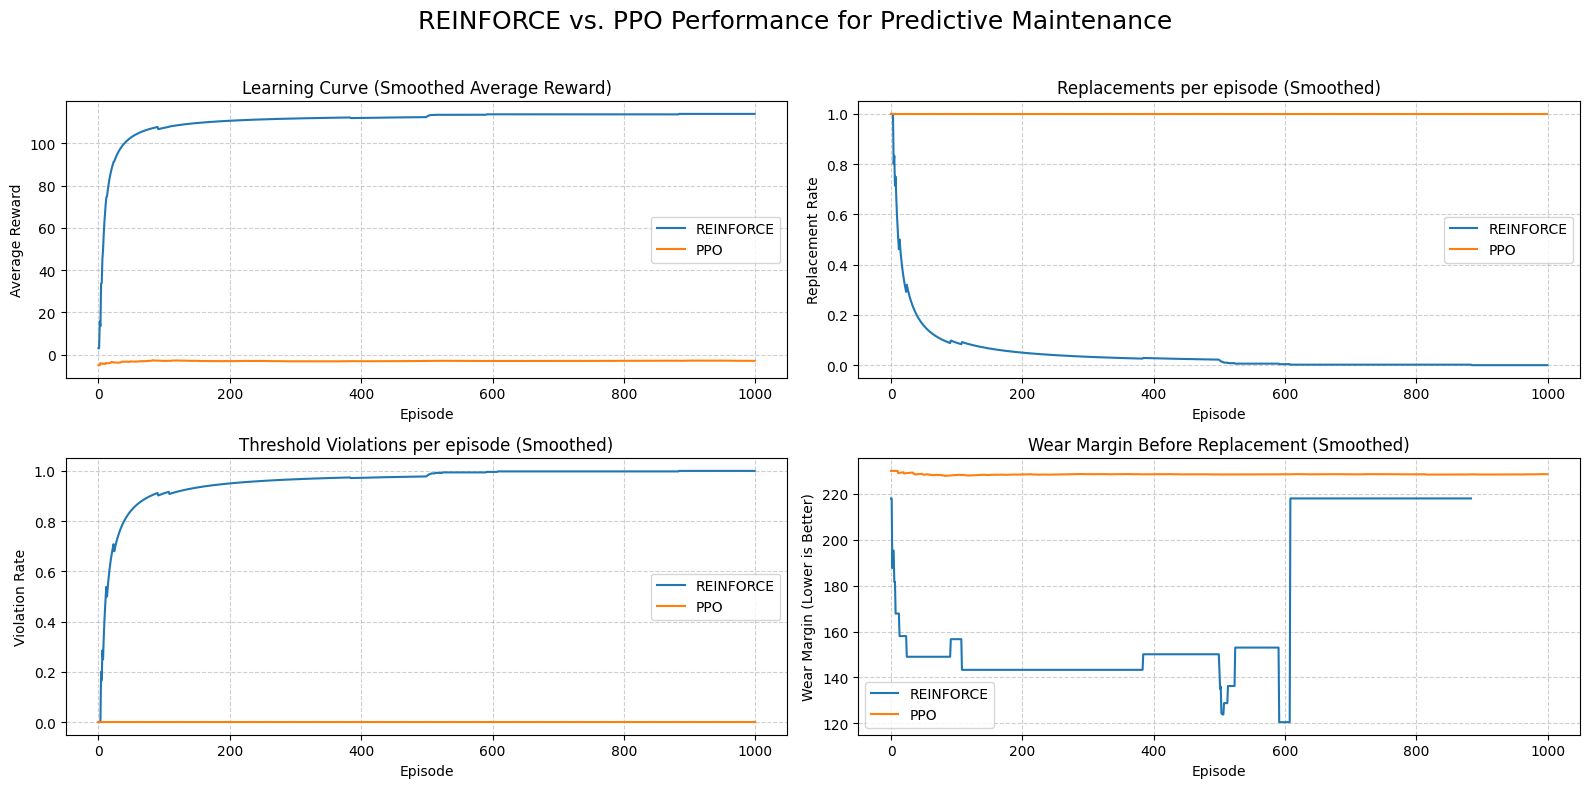

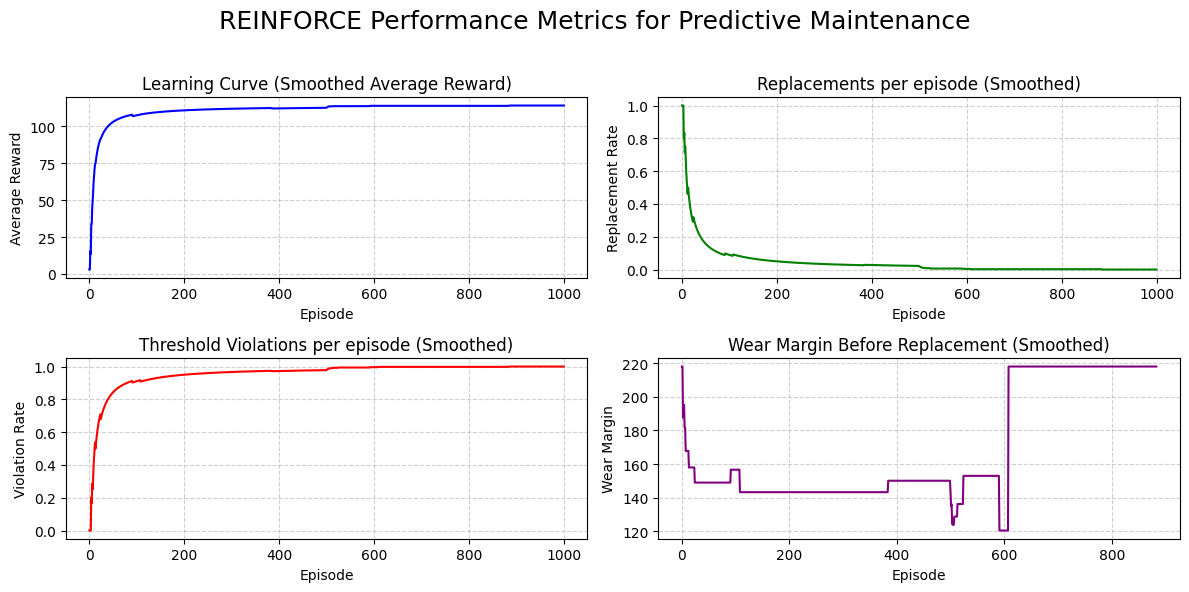

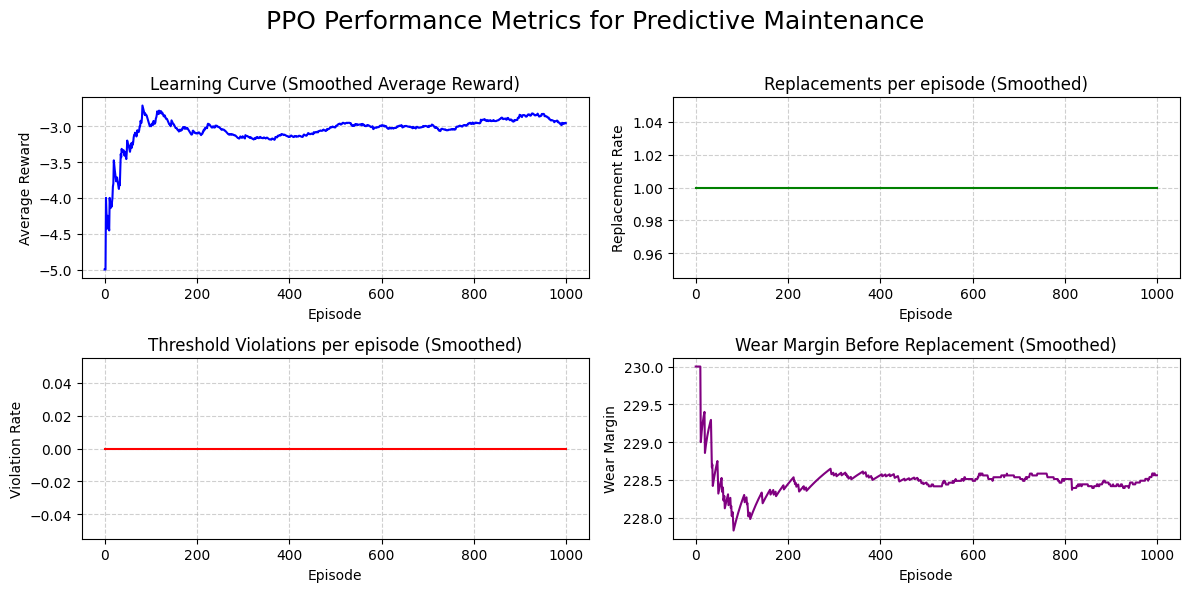

In [30]:
SMOOTH_WINDOW = 500 

# Plot the results
plot_metrics(reinforce_metrics, ppo_metrics, window=SMOOTH_WINDOW)
plot_metrics_individual(reinforce_metrics, ppo_metrics, window=SMOOTH_WINDOW)